# Algorithmes d'estimation du prix d'un bien immobilier

- Nettoyage et encoding du dataset
- Algorithmes de régression linaire

## Importation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## I. Pre-pocessing

### 1. Nettoyage

- Observation du dataset
- Suppression des outliers

In [2]:
# Load data
# data_2020 = pd.read_csv("Immobilier_2020_clean.csv", sep = ',')
data = pd.read_csv("data/dataframe_final.csv", sep = ',', index_col=0)
# data_2018 = pd.read_csv("Immobilier_2018_clean.csv", sep = ',')
data['code_postal'] = data.code_postal.astype("str")
data.head()

,date_mutation,valeur_fonciere,code_postal,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,Commerce,Restaurant,Agence immobilière,...,Maternelle,Enseignement supérieur,Lycée,Crèche,Poste,Pharmacie,Urgences,Monument,Parc,Métro
0,2020-01-02,268800.0,75008,24.0,1,2.323937,48.871607,580,265,151,...,1,2,4,5,4,8,0,0,1,18
1,2020-01-06,878378.0,75001,66.0,2,2.326882,48.869331,696,264,139,...,0,3,2,1,2,11,0,1,0,22
2,2020-01-10,680000.0,75003,51.0,2,2.351965,48.864157,574,530,148,...,2,8,1,9,2,16,0,2,8,12
3,2020-01-03,852000.0,75003,12.0,1,2.363196,48.862017,485,270,113,...,3,9,2,8,2,10,0,0,11,7
4,2020-01-03,852000.0,75003,12.0,1,2.363196,48.862017,485,270,113,...,3,9,2,8,2,10,0,0,11,7


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34242 entries, 0 to 34241
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   date_mutation                    34242 non-null  object 
 1   valeur_fonciere                  34228 non-null  float64
 2   code_postal                      34242 non-null  object 
 3   surface_reelle_bati              34242 non-null  float64
 4   nombre_pieces_principales        34242 non-null  int64  
 5   longitude                        34216 non-null  float64
 6   latitude                         34216 non-null  float64
 7   Commerce                         34242 non-null  int64  
 8   Restaurant                       34242 non-null  int64  
 9   Agence immobilière               34242 non-null  int64  
 10  Boulangerie                      34242 non-null  int64  
 11  Banque                           34242 non-null  int64  
 12  Commerce alimentai

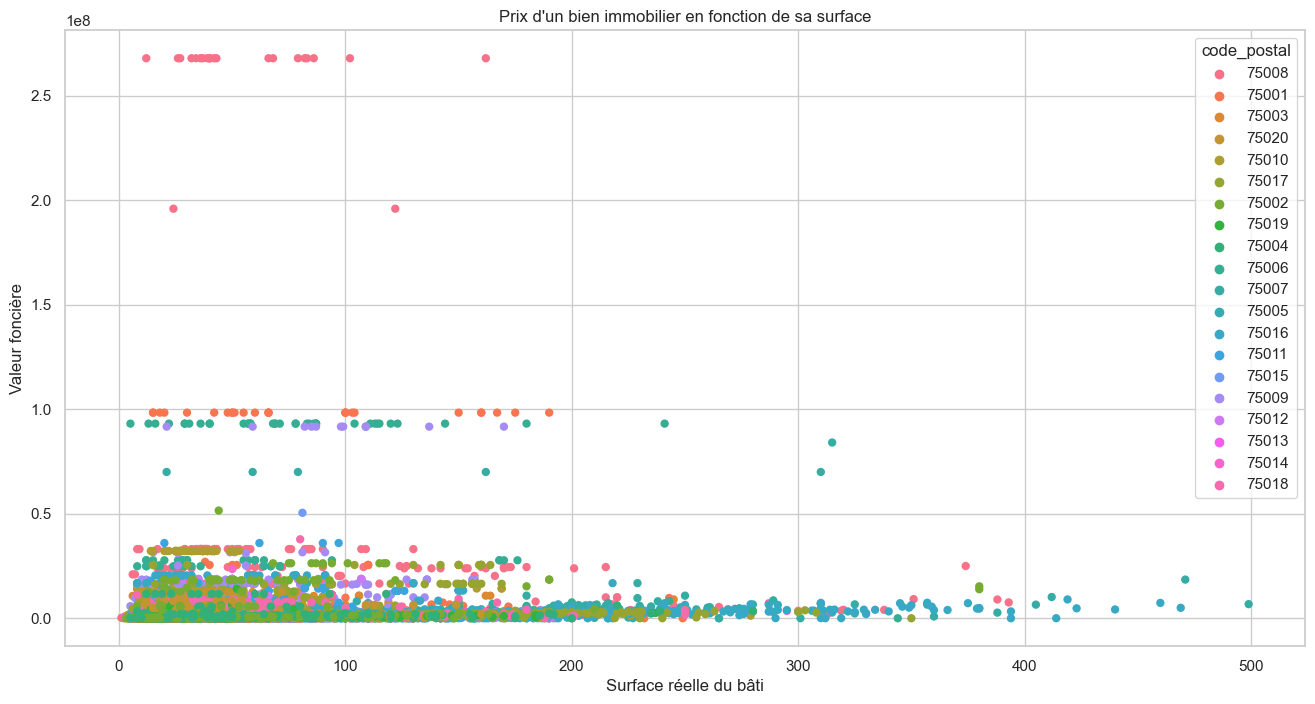

In [4]:
sns.set_theme(style="whitegrid", palette = 'deep')
f, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(x="surface_reelle_bati",y="valeur_fonciere",hue="code_postal",data=data, linewidth=0,ax=ax)
ax.set_xlabel('Surface réelle du bâti')
ax.set_ylabel('Valeur foncière')
ax.set_title("Prix d'un bien immobilier en fonction de sa surface")
plt.show()

On observe une forte dispersion des prix en fonction de la surface avec des prix improbables pour certains biens. Par exemple, des biens très grand et un peiw très faible et inversement des biens très petits et très chère. 
Nous savons que le prix moyen au m^2 des biens immobiliers à Paris était de 11000€ en 2020. 

Nous décidons donc de sélectionner les biens dont **le prix au m^2 est supérieur à 5000€ et inférieur à 23000€**.

Par ailleurs, nous baserons notre analyse seulement sur les biens immobiliers dont **la surface est inférieur à 300m^2** (les biens d'une superfice supérieure à 300m^2 sont des biens d'exception, rares)

In [5]:
def reduce_par_prix_m2(data):
  data = data [data ["valeur_fonciere"]/data["surface_reelle_bati"] > 5000]
  data = data [data ["valeur_fonciere"]/data["surface_reelle_bati"] < 23000]

  data= data.loc[data["surface_reelle_bati"] < 300]
  data.reset_index(inplace=True,drop=True)


  return data

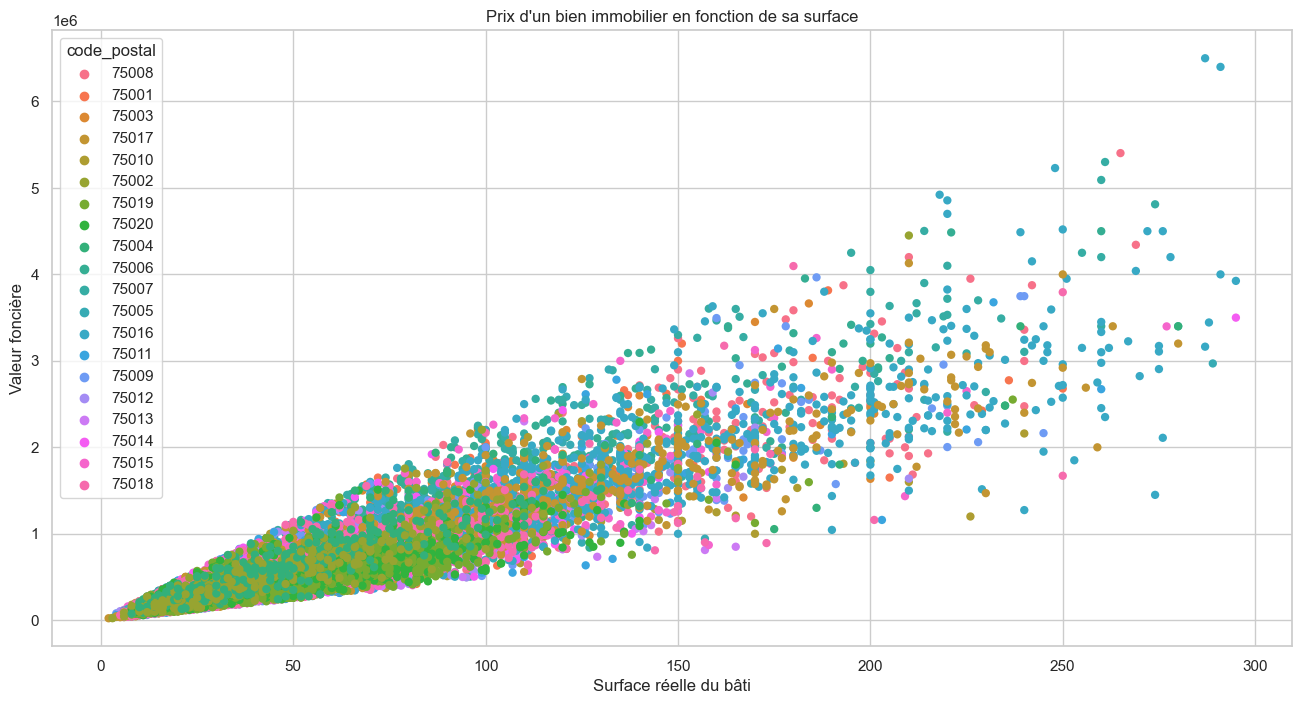

In [6]:
wrk_data=reduce_par_prix_m2(data) #selection des biens immobiliers avec un prix au m^2 réaliste
f, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(x="surface_reelle_bati",y="valeur_fonciere",hue="code_postal",data=wrk_data, linewidth=0,ax=ax)
ax.set_xlabel('Surface réelle du bâti')
ax.set_ylabel('Valeur foncière')
ax.set_title("Prix d'un bien immobilier en fonction de sa surface")
plt.show()

<AxesSubplot:xlabel='surface_reelle_bati'>

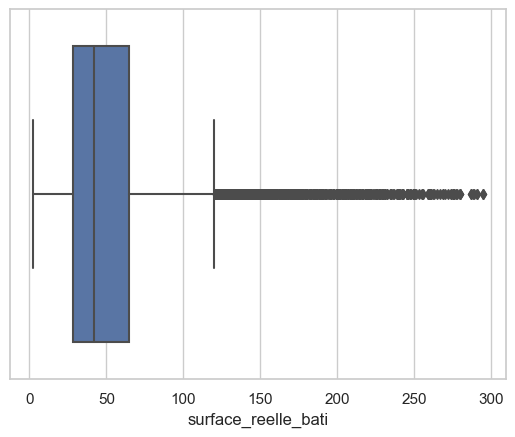

In [7]:
sns.boxplot(x=wrk_data['surface_reelle_bati'])

Text(0, 0.5, 'prix de vente')

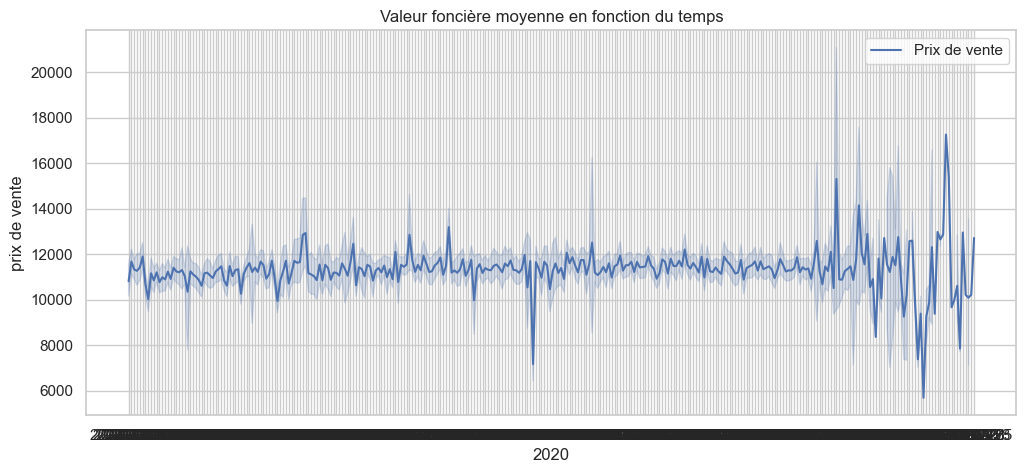

In [8]:
plt.figure( figsize = ( 12, 5)) 
  
sns.lineplot( x = 'date_mutation', 
            y = wrk_data['valeur_fonciere']/wrk_data['surface_reelle_bati'], 
           data = wrk_data, 
           label = 'Prix de vente') 
  
plt.xlabel( "2020") 

plt.title("Valeur foncière moyenne en fonction du temps")

plt.ylabel('prix de vente')

### Analyse des corrélations

<AxesSubplot:>

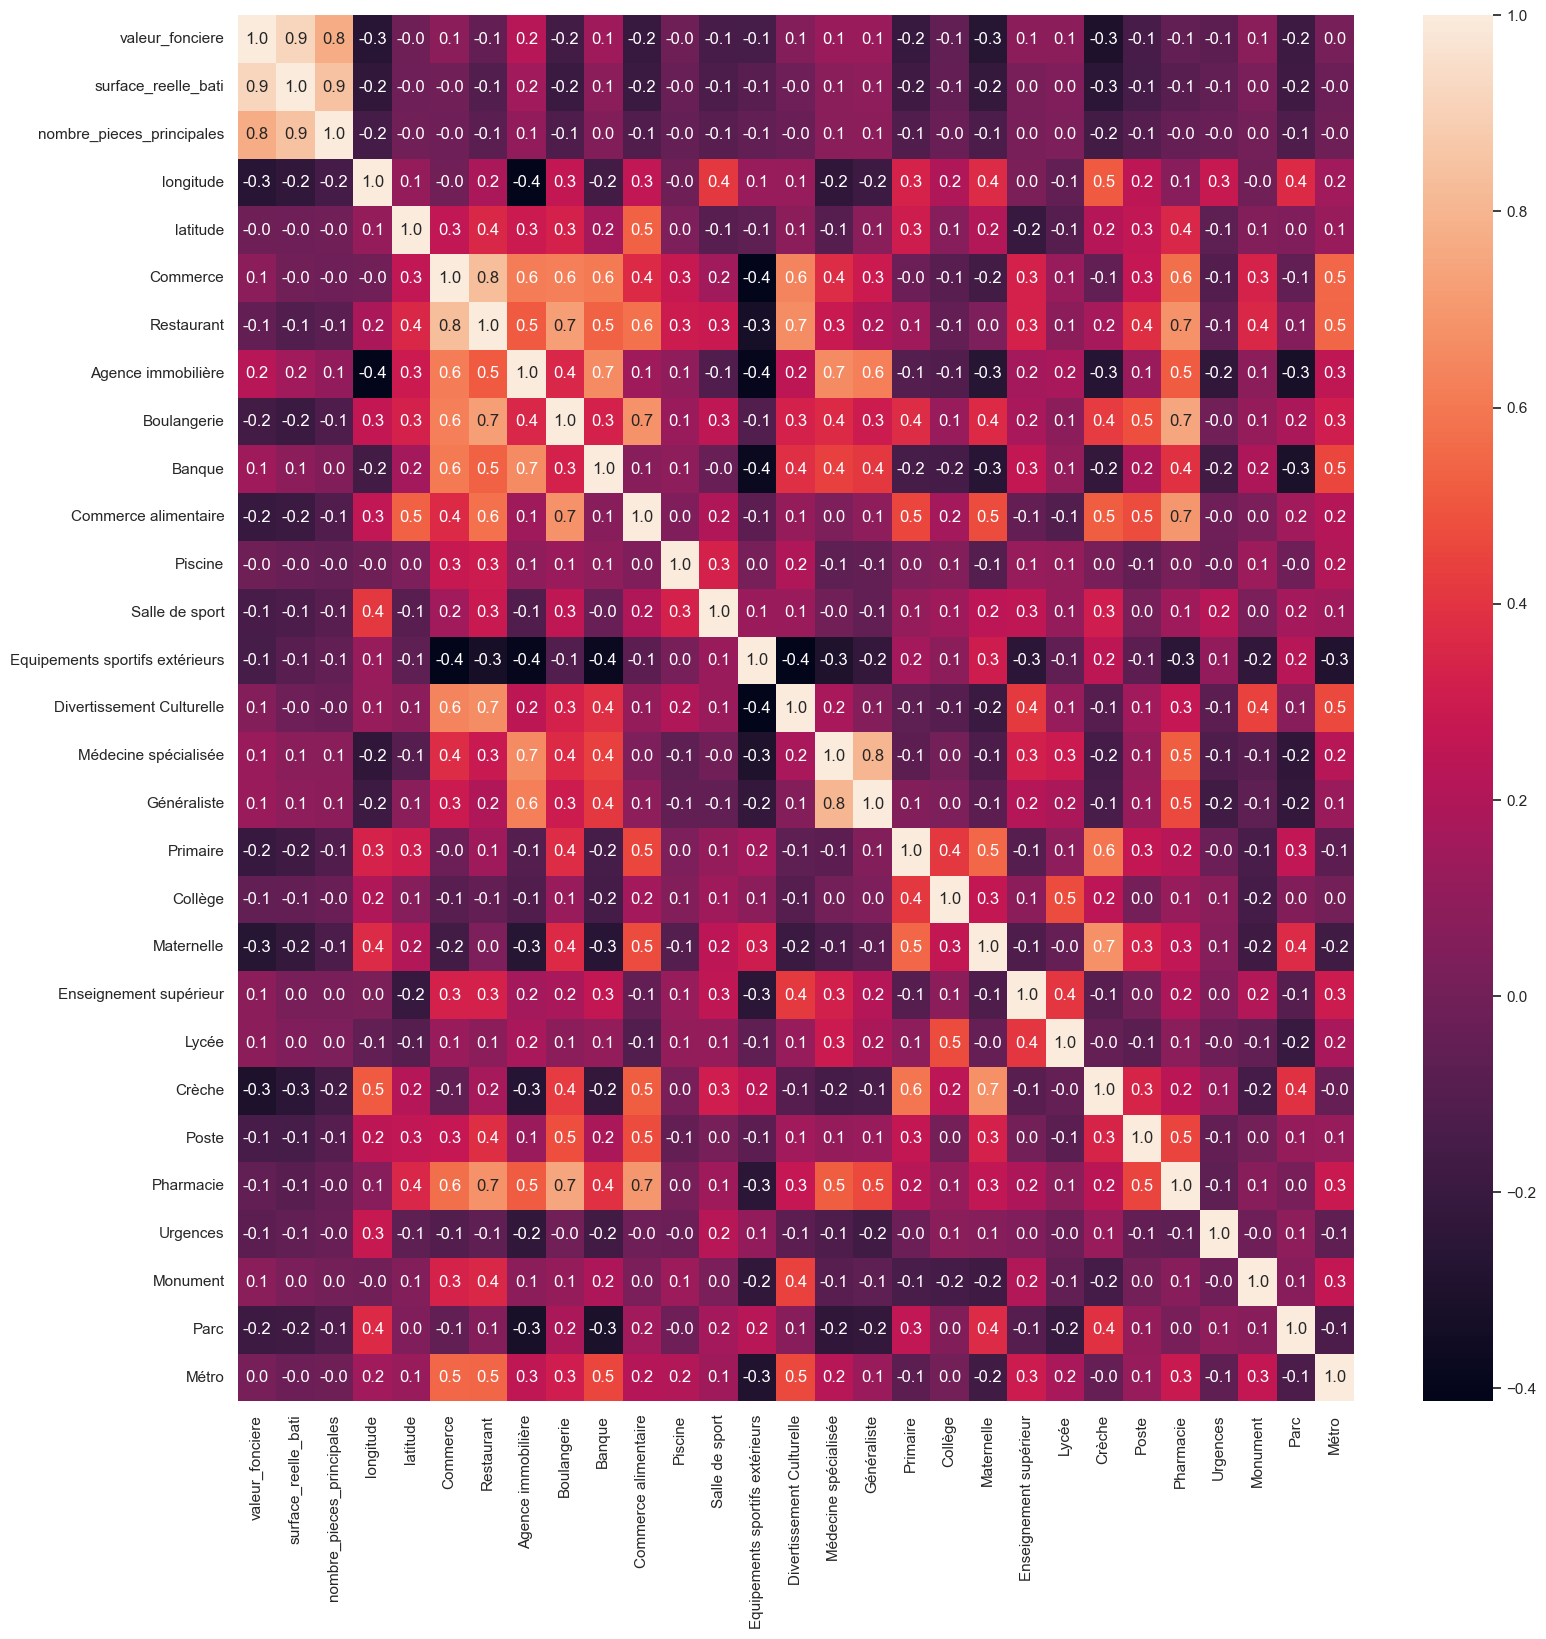

In [9]:
#Correlation matrix
f=plt.subplots(figsize=(18,18))
sns.heatmap(wrk_data.corr(),annot=True,fmt='.1f',color='green')

Les features corrélées linéairement sont :
*   commerce - Agences, Banque, Restaurant, divertissement culturelle, 
*   généraliste - Médecin spécialisé
*   Surface_réélle - Nb de pièces
*   code_postal - , Maternelle, commerce
*   Commerce alimentaire - boulangerie - poste
*   longitude - crèche
*   primaire - crèche - maternelle
*   Banque - Metro

In [10]:
wrk_data.drop(columns=['latitude','longitude','Divertissement Culturelle','Primaire','Agence immobilière','Crèche','Restaurant','Commerce','Pharmacie','Lycée','Enseignement supérieur','Médecine spécialisée','nombre_pieces_principales', 'Poste', 'Commerce alimentaire', 'Banque'],inplace=True)
wrk_data

,date_mutation,valeur_fonciere,code_postal,surface_reelle_bati,Boulangerie,Piscine,Salle de sport,Equipements sportifs extérieurs,Généraliste,Collège,Maternelle,Urgences,Monument,Parc,Métro
0,2020-01-02,268800.0,75008,24.0,19,1,5,0,30,1,1,0,0,1,18
1,2020-01-06,878378.0,75001,66.0,28,2,5,0,22,0,0,0,1,0,22
2,2020-01-10,680000.0,75003,51.0,38,4,15,1,21,1,2,0,2,8,12
3,2020-01-03,2350000.0,75008,174.0,17,0,3,0,31,3,1,0,0,5,5
4,2020-01-03,2350000.0,75008,212.0,17,0,3,0,31,3,1,0,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27860,2020-12-29,355000.0,75004,32.0,21,0,5,2,21,2,3,0,0,12,12
27861,2020-12-29,151000.0,75004,10.0,24,1,2,1,12,2,3,1,3,20,3
27862,2020-12-23,160010.0,75002,14.0,31,5,16,1,22,1,2,0,2,8,11
27863,2020-12-16,1937500.0,75004,110.0,25,0,0,0,12,1,0,1,7,15,13


<AxesSubplot:>

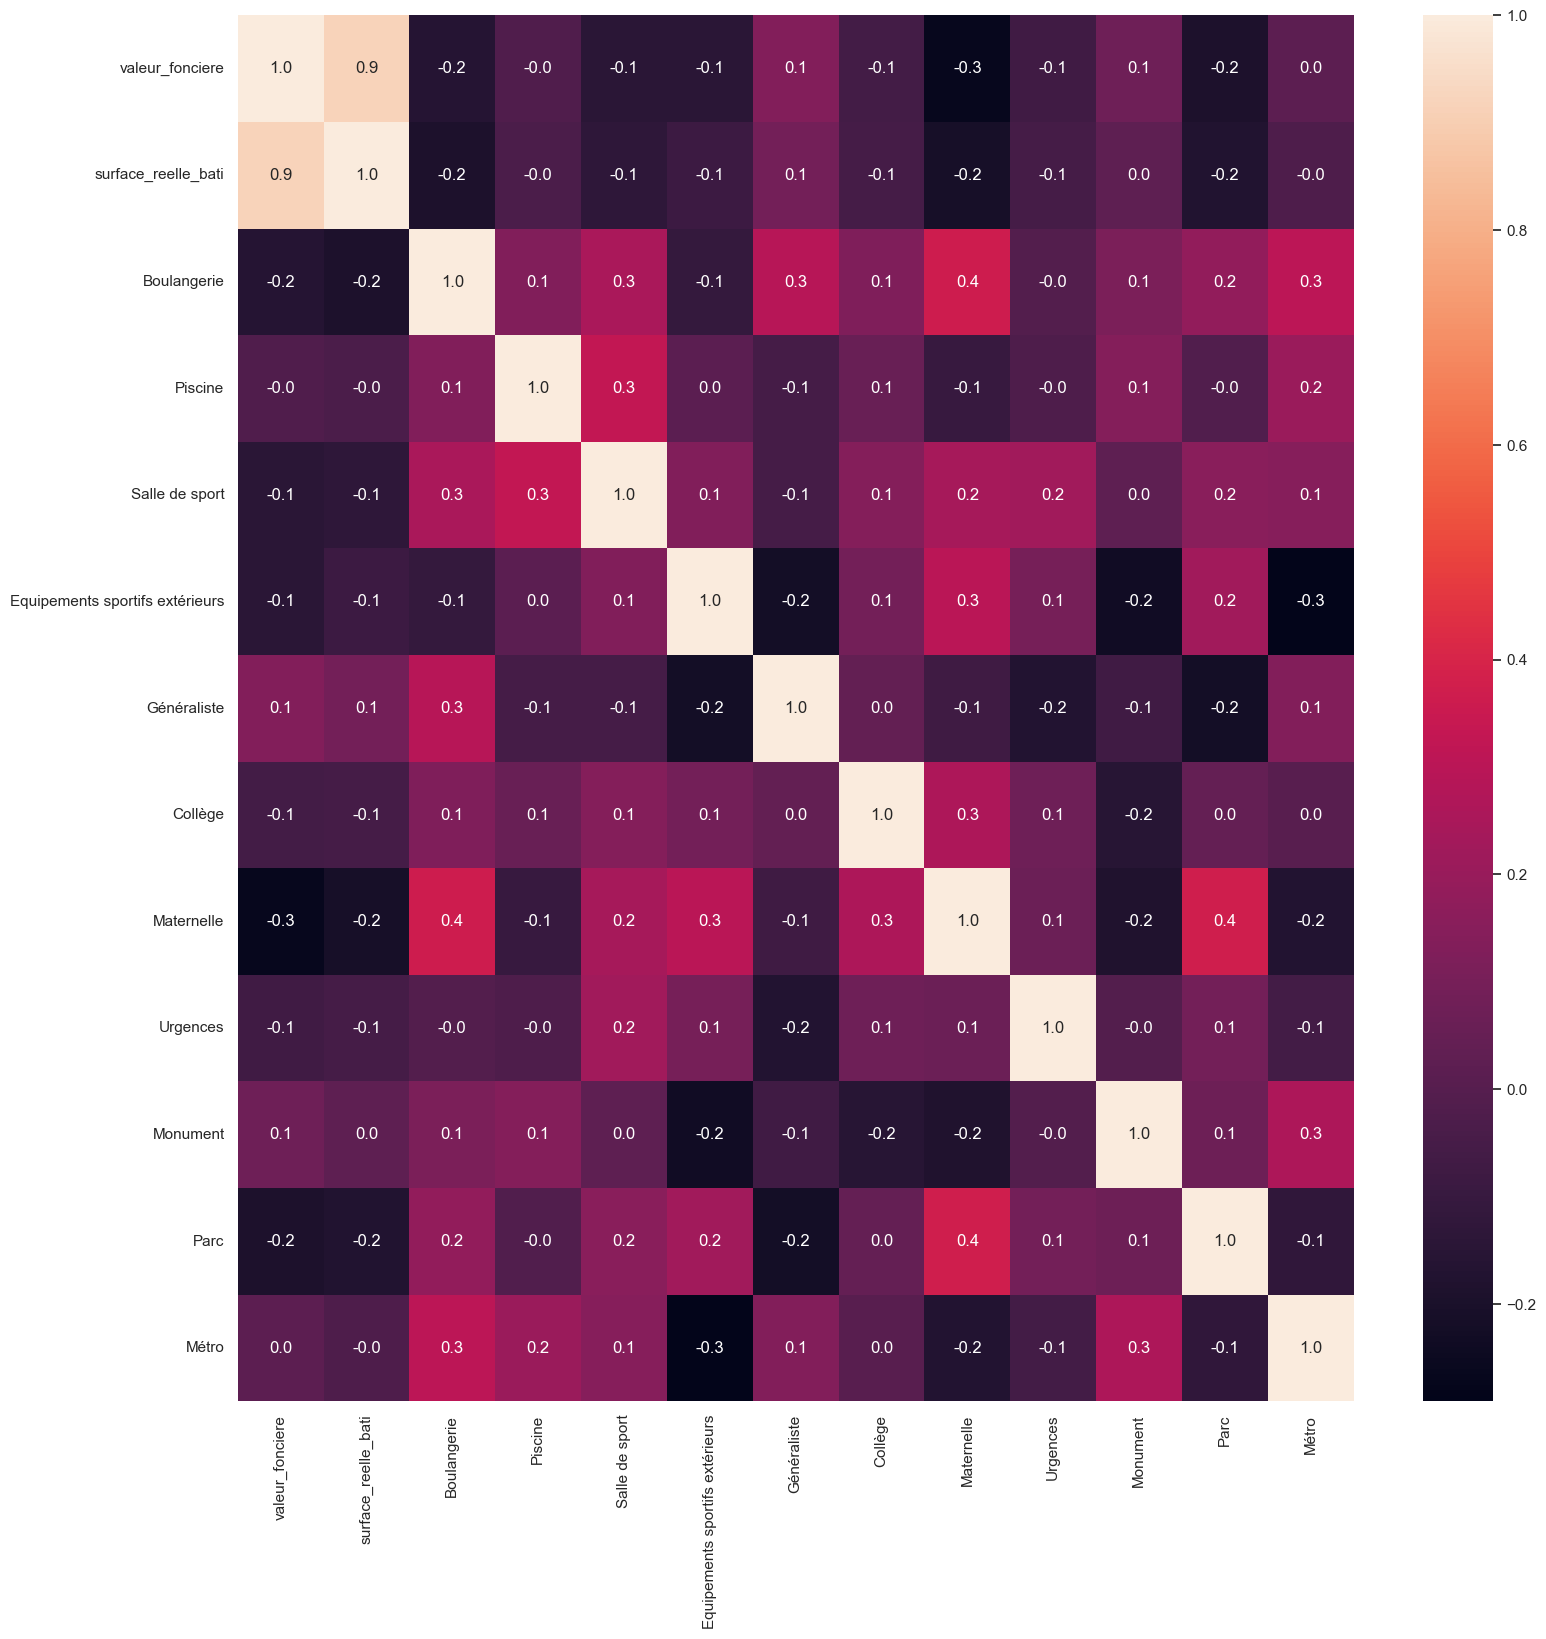

In [11]:
#Correlation matrix
f=plt.subplots(figsize=(18,18))
sns.heatmap(wrk_data.corr(),annot=True,fmt='.1f',color='green')

### 2. Encodage

- Les variables catégorielles ne peuvent pas être traiter par les algorithmes de machine learning et doivent être **encodé**, i.e. convertir en variables numériques. 
- Les variables numériques doivent être **standartisées**

La seule variable catégorielle de notre dataset est le *code postal*. Nous allons l'encoder grâce à une OneHotEncoding.

Dans notre étude, nous allons ignorer la date de mutation (date de vente) du bien car le prix de vente des biens est assez stable au cours d'une année.

In [12]:
from sklearn.preprocessing import StandardScaler

"""
Fonction pour normaliser les données numériques d'un Dataframe 
+ onehot encode de code postale
---
Input : df, Dataframe
Output : dfScale, Scaled Dataframe
"""
def prepocessing_data(df):
  wrk_data=df.copy()
  df=df.drop(columns=['code_postal'])
  X = df.to_numpy() 
  std_scale = StandardScaler().fit(X)
  X_scaled = std_scale.transform(X)

  dfScale=pd.DataFrame(X_scaled,columns=df.columns,index=df.index)
  dfScale['code_postal']=wrk_data['code_postal']
  dfScale= pd.get_dummies(dfScale, columns = ['code_postal'])

  return dfScale

wrk_data.drop(columns=["date_mutation"],inplace=True)

dfScale = prepocessing_data(wrk_data)

wrk_data_encoded = pd.get_dummies(wrk_data, columns = ['code_postal'])

dfScale.head()

,valeur_fonciere,surface_reelle_bati,Boulangerie,Piscine,Salle de sport,Equipements sportifs extérieurs,Généraliste,Collège,Maternelle,Urgences,...,code_postal_75011,code_postal_75012,code_postal_75013,code_postal_75014,code_postal_75015,code_postal_75016,code_postal_75017,code_postal_75018,code_postal_75019,code_postal_75020
0,-0.662543,-0.772955,-0.389879,0.310237,-0.549606,-1.072954,1.620792,-0.833819,-1.377659,-0.407376,...,0,0,0,0,0,0,0,0,0,0
1,0.554305,0.382540,0.757941,1.451911,-0.549606,-1.072954,0.494804,-1.534260,-1.874018,-0.407376,...,0,0,0,0,0,0,0,0,0,0
2,0.158300,-0.030137,2.033296,3.735258,1.914438,-0.573524,0.354056,-0.833819,-0.881299,-0.407376,...,0,0,0,0,0,0,0,0,0,0
3,3.491980,3.353813,-0.644950,-0.831437,-1.042415,-1.072954,1.761540,0.567065,-1.377659,-0.407376,...,0,0,0,0,0,0,0,0,0,0
4,3.491980,4.399261,-0.644950,-0.831437,-1.042415,-1.072954,1.761540,0.567065,-1.377659,-0.407376,...,0,0,0,0,0,0,0,0,0,0


### 3. Clustering par surface du bien

Nous allons tester nos algorithmes sur le dataset entier et sur des datatsets qui correspondent à intervalles de surface du dataset.

In [13]:
def reduce_par_surface(data):
  data1 = data.copy()
  data2 = data.copy()
  data3 = data.copy()
  data4 = data.copy()
  data5 = data.copy()

  data1 = data1 [data1 ["surface_reelle_bati"] <= 21.5]

  data2 = data2 [data2 ["surface_reelle_bati"] > 22.5]
  data2 = data2 [data2 ["surface_reelle_bati"] <= 44.5]

  data3 = data3 [data3 ["surface_reelle_bati"] > 44.5]
  data3 = data3 [data3 ["surface_reelle_bati"] <= 75.5]

  data4 = data4 [data4 ["surface_reelle_bati"] > 75.5]
  data4 = data4 [data4 ["surface_reelle_bati"] <= 159.5]

  data5 = data5 [data5 ["surface_reelle_bati"] > 159.5]

  return data1, data2, data3, data4, data5

In [14]:
data1, data2, data3, data4, data5 = reduce_par_surface(wrk_data)
data1.reset_index(inplace=True,drop=True)
data2.reset_index(inplace=True,drop=True)
data3.reset_index(inplace=True,drop=True)
data4.reset_index(inplace=True,drop=True)
data5.reset_index(inplace=True,drop=True)

In [15]:
dataScale1=prepocessing_data(data1)
dataScale2=prepocessing_data(data2)
dataScale3=prepocessing_data(data3)
dataScale4=prepocessing_data(data4)
dataScale5=prepocessing_data(data5)

data1_encoded = pd.get_dummies(data1, columns = ['code_postal'])
data2_encoded = pd.get_dummies(data2, columns = ['code_postal'])
data3_encoded = pd.get_dummies(data3, columns = ['code_postal'])
data4_encoded = pd.get_dummies(data4, columns = ['code_postal'])
data5_encoded = pd.get_dummies(data5, columns = ['code_postal'])


## II. Algoritmes

In [16]:
def extract_data(data):
  y = data['valeur_fonciere']
  X = data.drop('valeur_fonciere', axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

  return X, y, X_train, X_test, y_train, y_test

In [17]:

Xdf, ydf, Xdf_train, Xdf_test, ydf_train, ydf_test = extract_data(wrk_data_encoded)
Xdfs, ydfs, Xdfs_train, Xdfs_test, ydfs_train, ydfs_test = extract_data(dfScale)


X2, y2, X2_train, X2_test, y2_train, y2_test = extract_data(data2_encoded)
Xs2,ys2, Xs2_train, Xs2_test, ys2_train, ys2_test = extract_data(dataScale2)

### 1. Elastic Net

In [24]:
from sklearn.linear_model import ElasticNet
from sklearn import metrics
from sklearn.metrics import r2_score

In [25]:
def elastic_net(X_train,y_train,X_test, y_test):
  regr = ElasticNet()
  regr = regr.fit(X_train,y_train)

  y_predEN = regr.predict(X_test)
  r2 = r2_score(y_test, y_predEN)
  print("R2 {}".format(r2))
  mae = metrics.mean_absolute_error(y_test, y_predEN)
  print("Mean Absolute Error {}".format(mae))
  mape = metrics.mean_absolute_percentage_error(y_test, y_predEN)
  print("Mean Absolute Percentage Error {}".format(mape))
  mse = metrics.mean_squared_error(y_test, y_predEN)
  print("Mean Squared Error {}".format(mse**0.5))

In [26]:
# Dataset Normal
elastic_net(Xdf_train,ydf_train,Xdf_test, ydf_test)

R2 0.8611039412858001
Mean Absolute Error 113802.62209278606
Mean Absolute Percentage Error 0.20961515956464558
Mean Squared Error 191046.19792608218


In [27]:
# Dataset Cluster
elastic_net(X2_train,y2_train,X2_test, y2_test)

R2 0.3787324297341462
Mean Absolute Error 62002.21501428415
Mean Absolute Percentage Error 0.1806057240435905
Mean Squared Error 87849.80151161879


In [28]:
# Dataset Standardisé
elastic_net(Xdfs_train,ydfs_train,Xdfs_test, ydfs_test)

R2 0.436985786834471
Mean Absolute Error 0.48953723267074556
Mean Absolute Percentage Error 1.0686450756787438
Mean Squared Error 0.7446008155702011


In [29]:
# X standardisé et y normal
elastic_net(Xdfs_train,ydf_train,Xdfs_test, ydf_test)

R2 -0.00045372378413999215
Mean Absolute Error 340233.98357343
Mean Absolute Percentage Error 0.865292356792596
Mean Squared Error 512733.79148689256


### 2. SVR Linéaire

In [30]:
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import r2_score

In [31]:
def svr(X_train,y_train,X_test, y_test):
  svr = SVR(kernel='linear') # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
  svr.fit(X_train,y_train)
  
  y_predSVR = svr.predict(X_test)
  r2 = r2_score(y_test, y_predSVR)
  print("R2 {}".format(r2))
  mae = metrics.mean_absolute_error(y_test, y_predSVR)
  print("Mean Absolute Error {}".format(mae))
  mape = metrics.mean_absolute_percentage_error(y_test, y_predSVR)
  print("Mean Absolute Percentage Error {}".format(mape))
  mse = metrics.mean_squared_error(y_test, y_predSVR)
  print("Root Mean Squared Error {}".format(mse**0.5))

In [32]:
def svr_scale(data):
  y = data['valeur_fonciere']
  y=np.array(y)
  y=y.reshape(-1, 1)
  X = data.drop('valeur_fonciere', axis=1)
  std_x=StandardScaler().fit(X)
  std_y=StandardScaler().fit(y)
  std_features=std_x.transform(X)
  std_labels=std_y.transform(y)
  X_train, X_test, y_train, y_test = train_test_split(std_features, std_labels, test_size=0.25, shuffle=True)
  svr = SVR(kernel='linear') # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
  svr.fit(X_train,y_train)
  X = data.to_numpy()
  y_predSVR = svr.predict(X_test)
  y_predSVR=np.array(y_predSVR)
  y_predSVR = std_y.inverse_transform(y_predSVR.reshape(-1,1))
  y_test = std_y.inverse_transform(y_test)
  r2 = r2_score(y_test, y_predSVR)
  print("R2 {}".format(r2))
  mae = metrics.mean_absolute_error(y_test, y_predSVR)
  print("Mean Absolute Error {}".format(mae))
  mape = metrics.mean_absolute_percentage_error(y_test, y_predSVR)
  print("Mean Absolute Percentage Error {}".format(mape))
  mse = metrics.mean_squared_error(y_test, y_predSVR)
  print("Root Mean Squared Error {}".format(mse**0.5))

In [33]:
# Dataset Normal
svr(Xdf_train,ydf_train,Xdf_test, ydf_test)

R2 0.8456692086122083
Mean Absolute Error 111801.54452926198
Mean Absolute Percentage Error 0.1908238053375976
Root Mean Squared Error 201381.57328386017


In [34]:
# Dataset Cluster normalize
print('data1')
print(svr_scale(data1))
print('data2')
print(svr_scale(data2))
print('data3')
print(svr_scale(data3))
print('data4')
print(svr_scale(data4))
print('data5')
print(svr_scale(data4))

data1


c:\Users\natac\miniconda3\envs\dsEnv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 0.428671513296765
Mean Absolute Error 37227.403376442606
Mean Absolute Percentage Error 0.2232005458345493
Root Mean Squared Error 50944.40683789547
None
data2


c:\Users\natac\miniconda3\envs\dsEnv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 0.40327795635725927
Mean Absolute Error 61026.52206171336
Mean Absolute Percentage Error 0.1758409698671462
Root Mean Squared Error 85884.43759997202
None
data3


c:\Users\natac\miniconda3\envs\dsEnv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 0.4097483321423837
Mean Absolute Error 99781.71537547943
Mean Absolute Percentage Error 0.16703983986991175
Root Mean Squared Error 145003.05862472023
None
data4


c:\Users\natac\miniconda3\envs\dsEnv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 0.5782632377245522
Mean Absolute Error 202065.41302379046
Mean Absolute Percentage Error 0.17996574984754138
Root Mean Squared Error 279889.01649517356
None
data5


c:\Users\natac\miniconda3\envs\dsEnv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 0.5640385770903871
Mean Absolute Error 215012.770025186
Mean Absolute Percentage Error 0.18113431281204936
Root Mean Squared Error 297308.72238548065
None


In [36]:
# Dataset Standardisé
svr_scale(dfScale)

c:\Users\natac\miniconda3\envs\dsEnv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 0.8561677985728994
Mean Absolute Error 0.2125870321978162
Mean Absolute Percentage Error 1.4116577021237486
Root Mean Squared Error 0.3807828546627342


In [37]:
# X standardisé et y normal
#svr(Xdfs_train,ydf_train,Xdfs_test, ydf_test)

### 3. Ridge

In [38]:
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.metrics import r2_score

In [39]:
def ridge(X_train,y_train,X_test, y_test):
  clf = Ridge() 
  clf.fit(X_train,y_train)

  y_predCLF = clf.predict(X_test)
  r2 = r2_score(y_test, y_predCLF)
  print("R2 {}".format(r2))
  mae = metrics.mean_absolute_error(y_test, y_predCLF)
  print("Mean Absolute Error {}".format(mae))
  mape = metrics.mean_absolute_percentage_error(y_test, y_predCLF)
  print("Mean Absolute Percentage Error {}".format(mape))
  mse = metrics.mean_squared_error(y_test, y_predCLF)
  print("Mean Squared Error {}".format(mse**0.5))

In [40]:
# Dataset Normal
ridge(Xdf_train,ydf_train,Xdf_test, ydf_test)

R2 0.870622105976351
Mean Absolute Error 109880.45217742525
Mean Absolute Percentage Error 0.21020314539799614
Mean Squared Error 184384.10373972708


In [41]:
# Dataset Cluster
ridge(X2_train,y2_train,X2_test, y2_test)

R2 0.41149045222298786
Mean Absolute Error 59678.260380064625
Mean Absolute Percentage Error 0.17366921333560212
Mean Squared Error 85502.37906775581


In [42]:
# Dataset Standardisé
ridge(Xdfs_train,ydfs_train,Xdfs_test, ydfs_test)

R2 0.8601679749312511
Mean Absolute Error 0.22044922935353675
Mean Absolute Percentage Error 1.520605779489284
Mean Squared Error 0.3710796615774524


In [43]:
# X standardisé et y normal
ridge(Xdfs_train,ydf_train,Xdfs_test, ydf_test)

R2 -0.0007241127937227532
Mean Absolute Error 340528.13805592136
Mean Absolute Percentage Error 0.8659362110049037
Mean Squared Error 512803.074159724


### 4. Gradient Boosting

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

In [45]:
def gradient_boosting(X_train,y_train,X_test, y_test):

  gbr=GradientBoostingRegressor()
  gbr.fit(X_train,y_train)

  y_predBGR = gbr.predict(X_test)
  r2 = r2_score(y_test, y_predBGR)
  print("R2 {}".format(r2))
  mae = metrics.mean_absolute_error(y_test, y_predBGR)
  print("Mean Absolute Error {}".format(mae))
  mape = metrics.mean_absolute_percentage_error(y_test, y_predBGR)
  print("Mean Absolute Percentage Error {}".format(mape))
  mse = metrics.mean_squared_error(y_test, y_predBGR)
  print("Root Mean Squared Error {}".format(mse**0.5))

In [46]:
# Dataset Normal
gradient_boosting(Xdf_train,ydf_train,Xdf_test, ydf_test)

R2 0.8817371551810412
Mean Absolute Error 101060.56840238137
Mean Absolute Percentage Error 0.18349395636722352
Root Mean Squared Error 176285.90873437937


In [47]:
# Dataset Cluster
gradient_boosting(X2_train,y2_train,X2_test, y2_test)

R2 0.42104409460414594
Mean Absolute Error 58722.24874714702
Mean Absolute Percentage Error 0.17070060628467995
Root Mean Squared Error 84805.53269883367


In [48]:
# Dataset Cluster normalisé
gradient_boosting(Xs2_train,ys2_train,Xs2_test, ys2_test)

R2 0.4539210729211385
Mean Absolute Error 0.5158920075043905
Mean Absolute Percentage Error 35.7296137278366
Root Mean Squared Error 0.7269441274484062


In [49]:
# Dataset Standardisé
gradient_boosting(Xdfs_train,ydfs_train,Xdfs_test, ydfs_test)

R2 0.8698711703239788
Mean Absolute Error 0.20225042915550642
Mean Absolute Percentage Error 1.2784408633077033
Root Mean Squared Error 0.35797326282337777


In [50]:
# X standardisé et y normal
gradient_boosting(Xdfs_train,ydf_train,Xdfs_test, ydf_test)

R2 -0.006904022723469794
Mean Absolute Error 341159.7332783105
Mean Absolute Percentage Error 0.8681665864945146
Root Mean Squared Error 514384.0289948222


### 5. XGBoosting

In [51]:
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

In [52]:
def xgb_regressor(X_train,y_train,X_test, y_test):

  xgbr=XGBRegressor()
  xgbr.fit(X_train,y_train)

  y_predXBGR = xgbr.predict(X_test)
  r2 = r2_score(y_test, y_predXBGR)
  print("R2 {}".format(r2))
  mae = metrics.mean_absolute_error(y_test, y_predXBGR)
  print("Mean Absolute Error {}".format(mae))
  mape = metrics.mean_absolute_percentage_error(y_test, y_predXBGR)
  print("Mean Absolute Percentage Error {}".format(mape))
  mse = metrics.mean_squared_error(y_test, y_predXBGR)
  print("Root Mean Squared Error {}".format(mse**0.5))

In [53]:
# Dataset Normal
xgb_regressor(Xdf_train,ydf_train,Xdf_test, ydf_test)

R2 0.8790091378920162
Mean Absolute Error 100151.77187614379
Mean Absolute Percentage Error 0.17605623583616858
Root Mean Squared Error 178307.54620659637


In [54]:
# Dataset Cluster
xgb_regressor(X2_train,y2_train,X2_test, y2_test)

R2 0.38244229063172896
Mean Absolute Error 62761.58136831576
Mean Absolute Percentage Error 0.18092590874458772
Root Mean Squared Error 87587.11393875258


In [55]:
# Dataset Standardisé
xgb_regressor(Xdfs_train,ydfs_train,Xdfs_test, ydfs_test)

R2 0.8641049127945019
Mean Absolute Error 0.20126976353893575
Mean Absolute Percentage Error 1.26968064358746
Root Mean Squared Error 0.365818535334665


In [56]:
# X standardisé et y normal
xgb_regressor(Xdfs_train,ydf_train,Xdfs_test, ydf_test)

R2 -0.0870503547910082
Mean Absolute Error 356259.1969967907
Mean Absolute Percentage Error 0.8996957973873962
Root Mean Squared Error 534463.7676921433


### 6. Régression Linéaire

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score

In [58]:
def result_linear_regression(X_train,y_train,X_test, y_test):
  lr=LinearRegression()
  lr.fit(X_train,y_train)

  y_predLR = lr.predict(X_test)
  r2 = r2_score(y_test, y_predLR)
  print("R2 {}".format(r2))
  mae = metrics.mean_absolute_error(y_test, y_predLR)
  print("Mean Absolute Error {}".format(mae))
  mape = metrics.mean_absolute_percentage_error(y_test, y_predLR)
  print("Mean Absolute Percentage Error {}".format(mape))
  mse = metrics.mean_squared_error(y_test, y_predLR)
  print("Mean Squared Error {}".format(mse**0.5))

In [59]:
# Dataset Normal
result_linear_regression(Xdf_train,ydf_train,Xdf_test, ydf_test)

R2 0.8706219940753538
Mean Absolute Error 109889.02194908919
Mean Absolute Percentage Error 0.21025124004404297
Mean Squared Error 184384.1834780811


In [60]:
# Dataset Cluster
result_linear_regression(X2_train,y2_train,X2_test, y2_test)

R2 0.41143631021402194
Mean Absolute Error 59683.28117257889
Mean Absolute Percentage Error 0.1736806171082383
Mean Squared Error 85506.31202358037


In [61]:
# Dataset Standardisé
result_linear_regression(Xdfs_train,ydfs_train,Xdfs_test, ydfs_test)

R2 0.8601705605045467
Mean Absolute Error 0.22047001660825957
Mean Absolute Percentage Error 1.5209247702465003
Mean Squared Error 0.3710762308250969


In [62]:
# X standardisé et y normal
result_linear_regression(Xdfs_train,ydf_train,Xdfs_test, ydf_test)

R2 -0.0007248130165977695
Mean Absolute Error 340528.65090388205
Mean Absolute Percentage Error 0.8659364144498904
Mean Squared Error 512803.2535680022


### 7. Arbre de décision

In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics,tree
from sklearn.metrics import r2_score

In [64]:
def dtr(X_train, y_train, X_test, y_test):
  clf = DecisionTreeRegressor()
  clf = clf.fit(X_train,y_train)

  y_predDTR = clf.predict(X_test)
  r2 = r2_score(y_test, y_predDTR)
  print("R2 {}".format(r2))
  mae = metrics.mean_absolute_error(y_test, y_predDTR)
  print("Mean Absolute Error {}".format(mae))
  mape = metrics.mean_absolute_percentage_error(y_test, y_predDTR)
  print("Mean Absolute Percentage Error {}".format(mape))
  mse = metrics.mean_squared_error(y_test, y_predDTR)
  print("Mean Squared Error {}".format(mse**0.5))

In [65]:
# Dataset Normal
dtr(Xdf_train,ydf_train,Xdf_test, ydf_test)

R2 0.7688321003580317
Mean Absolute Error 142506.73456849865
Mean Absolute Percentage Error 0.24813044534024364
Mean Squared Error 246466.10475506017


In [66]:
# Dataset Cluster
dtr(X2_train,y2_train,X2_test, y2_test)

R2 -0.08737662443811889
Mean Absolute Error 84400.29597188569
Mean Absolute Percentage Error 0.24316654853939046
Mean Squared Error 116222.82800233815


In [67]:
# Dataset Standardisé
dtr(Xdfs_train,ydfs_train,Xdfs_test, ydfs_test)

R2 0.7556616789780984
Mean Absolute Error 0.2858750553327967
Mean Absolute Percentage Error 2.4345206225754517
Mean Squared Error 0.49052327691847664


In [68]:
# X standardisé et y normal
dtr(Xdfs_train,ydf_train,Xdfs_test, ydf_test)

R2 -1.124826395086898
Mean Absolute Error 487730.5210751593
Mean Absolute Percentage Error 1.1804736353712009
Mean Squared Error 747231.4872638382


### 8. Arbre de décision et Random Forest

In [69]:
from IPython.display import Image
import pydot
from six import StringIO
from sklearn import tree, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pydotplus

In [70]:
def DecisionTreeRegressor(X_train, y_train, X_test, y_test, critere):
  clf = tree.DecisionTreeRegressor(criterion = critere, max_depth = 3, min_samples_split=2, min_samples_leaf=1)
  clf = clf.fit(X_train,y_train)

  y_predDTR = clf.predict(X_test)
  r2 = r2_score(y_test, y_predDTR)
  print("R2 {}".format(r2))
  mae = metrics.mean_absolute_error(y_test, y_predDTR)
  print("Mean Absolute Error {}".format(mae))
  mape = metrics.mean_absolute_percentage_error(y_test, y_predDTR)
  print("Mean Absolute Percentage Error {}".format(mape))
  mse = metrics.mean_squared_error(y_test, y_predDTR)
  print("Mean Squared Error {}".format(mse**0.5))

In [71]:
# Dataset Normal
DecisionTreeRegressor(Xdf_train,ydf_train,Xdf_test, ydf_test, "absolute_error")

R2 0.8058222352323772
Mean Absolute Error 128601.15145256207
Mean Absolute Percentage Error 0.2282226946610101
Mean Squared Error 225888.0137182342


In [72]:
# Dataset Cluster
DecisionTreeRegressor(X2_train,y2_train,X2_test, y2_test, "absolute_error")

R2 0.31774405294129504
Mean Absolute Error 65487.031338797824
Mean Absolute Percentage Error 0.1871581784756939
Mean Squared Error 92060.87691868798


In [73]:
# Dataset Standardisé
DecisionTreeRegressor(Xdfs_train,ydfs_train,Xdfs_test, ydfs_test, "absolute_error")

R2 0.7992783423918748
Mean Absolute Error 0.25597503681145556
Mean Absolute Percentage Error 1.7503058803963625
Mean Squared Error 0.4445912853799957


In [74]:
# X standardisé et y normal
DecisionTreeRegressor(Xdfs_train,ydf_train,Xdfs_test, ydf_test, "absolute_error")

R2 -0.09382136841732902
Mean Absolute Error 318607.4403286923
Mean Absolute Percentage Error 0.622906844776285
Mean Squared Error 536125.7163010609


In [75]:
# Dataset Normal
DecisionTreeRegressor(Xdf_train,ydf_train,Xdf_test, ydf_test, "friedman_mse")

R2 0.824564262086882
Mean Absolute Error 131223.98078972023
Mean Absolute Percentage Error 0.26259100341118985
Mean Squared Error 214710.09881205944


In [76]:
# Dataset Cluster
DecisionTreeRegressor(X2_train,y2_train,X2_test, y2_test, "friedman_mse")

R2 0.33333502219131017
Mean Absolute Error 65566.62619337825
Mean Absolute Percentage Error 0.1930564363286433
Mean Squared Error 91002.9063989587


In [77]:
# Dataset Standardisé
DecisionTreeRegressor(Xdfs_train,ydfs_train,Xdfs_test, ydfs_test, "friedman_mse")

R2 0.8198256175267392
Mean Absolute Error 0.26246034636602766
Mean Absolute Percentage Error 1.6837701173672177
Mean Squared Error 0.42122132446054206


In [78]:
# X standardisé et y normal
DecisionTreeRegressor(Xdf_train,ydf_train,Xdf_test, ydf_test, "friedman_mse")

R2 0.824564262086882
Mean Absolute Error 131223.98078972023
Mean Absolute Percentage Error 0.2625910034111899
Mean Squared Error 214710.09881205944


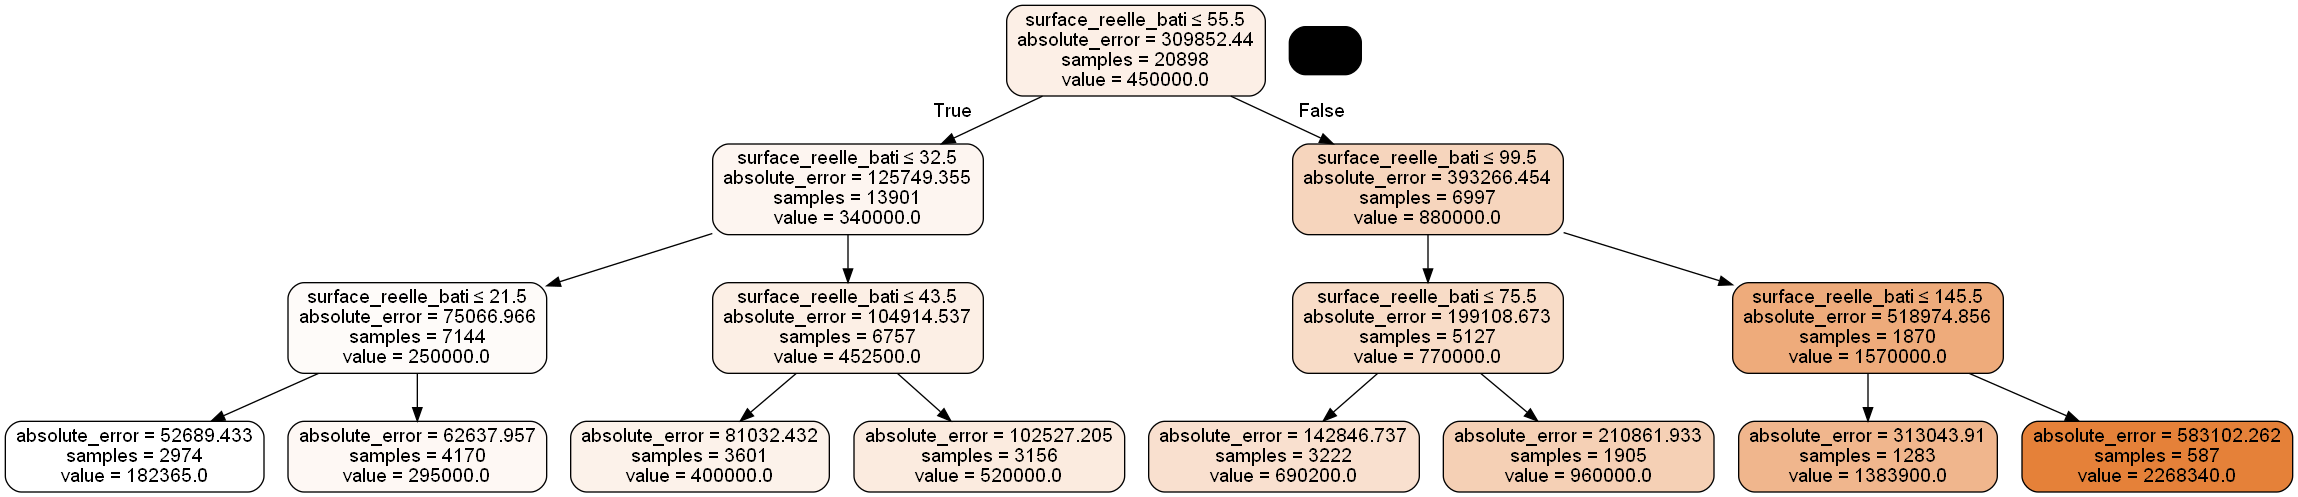

In [80]:
# Default decision tree classifier
# Default impurity measure is gini
# Decision tree with impurity measure information: use criterion = "entropy"
list_features=wrk_data_encoded.columns.tolist()
del list_features[list_features.index('valeur_fonciere')]
clf = tree.DecisionTreeRegressor(criterion = "absolute_error", max_depth = 3, min_samples_split=2, min_samples_leaf=1)
clf = clf.fit(Xdf_train, ydf_train)
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,
            feature_names=list_features,
            filled=True, rounded=True,
            special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

In [81]:
list_features_scale=dfScale.columns.tolist()
del list_features_scale[list_features_scale.index('valeur_fonciere')]

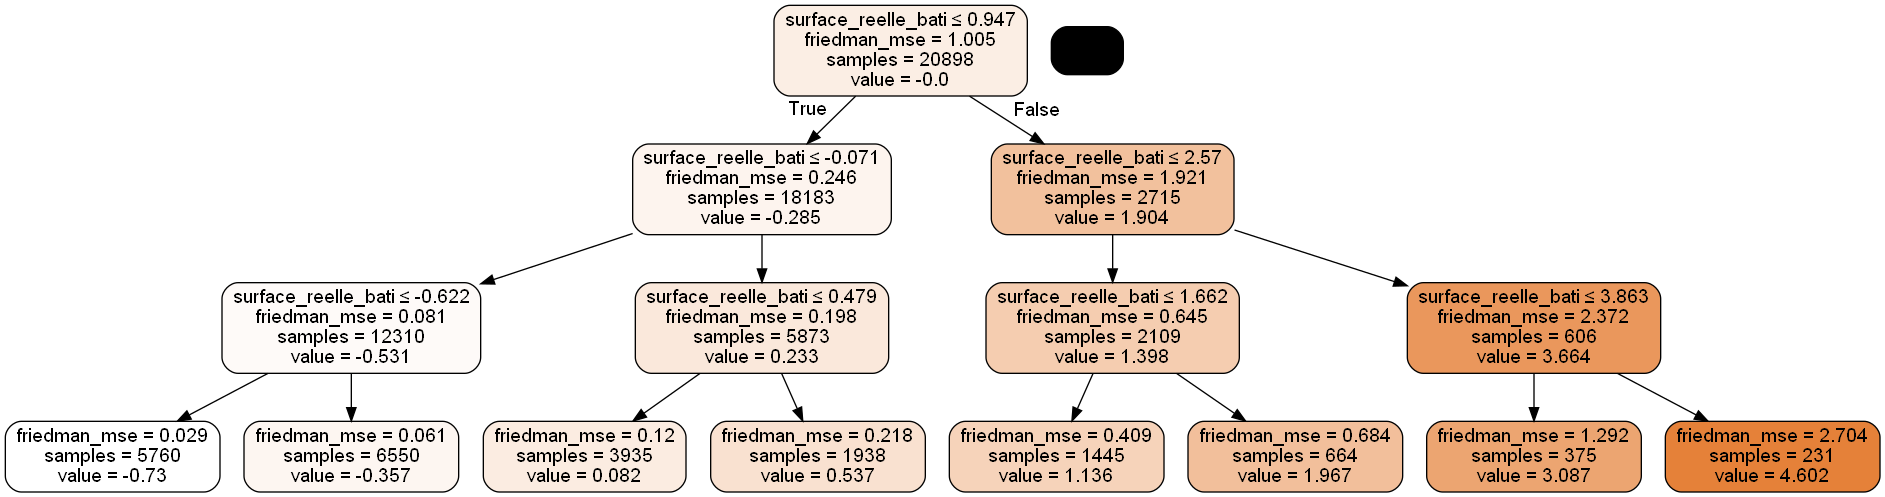

In [82]:
clfs = tree.DecisionTreeRegressor(criterion = "friedman_mse", max_depth = 3, min_samples_split=2, min_samples_leaf=1)
clfs = clfs.fit(Xdfs_train, ydfs_train)
dot_data = StringIO()
tree.export_graphviz(clfs, out_file=dot_data,
            feature_names=list_features_scale,
            filled=True, rounded=True,
            special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

### 9. KNN Regressor

In [89]:
#import required packages
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [90]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

In [91]:
def kNNR(X_train,y_train,X_test, y_test):
  for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, y_train)  #fit the model

    pred = model.predict(X_test) #make prediction on test set
    error = metrics.mean_absolute_percentage_error(y_test,pred) #calculate rmse
    
    print('MAPE value for k= ' , K , 'is:', error)

In [92]:
def kNNR_scale(data):
  y = data['valeur_fonciere']
  y=np.array(y)
  y=y.reshape(-1, 1)
  X = data.drop('valeur_fonciere', axis=1)
  std_x=StandardScaler().fit(X)
  std_y=StandardScaler().fit(y)
  std_features=std_x.transform(X)
  std_labels=std_y.transform(y)
  X_train, X_test, y_train, y_test = train_test_split(std_features, std_labels, test_size=0.25, shuffle=True)
  for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train, y_train)  #fit the model

    pred = model.predict(X_test) #make prediction on test set
    pred=np.array(pred)
    pred= std_y.inverse_transform(pred.reshape(-1,1))
    y_test = std_y.inverse_transform(y_test)
    error = metrics.mean_absolute_percentage_error(y_test,pred) #calculate rmse
    
    print('MAPE value for k= ' , K , 'is:', error)

In [93]:
# Dataset Normal
kNNR(Xdf_train,ydf_train,Xdf_test, ydf_test)

MAPE value for k=  1 is: 0.23913840755293436
MAPE value for k=  2 is: 0.21527454109241292
MAPE value for k=  3 is: 0.20605611612518154
MAPE value for k=  4 is: 0.19965324941455068
MAPE value for k=  5 is: 0.19655211474486692
MAPE value for k=  6 is: 0.19547219471107677
MAPE value for k=  7 is: 0.19377963834847317
MAPE value for k=  8 is: 0.19244402369998226
MAPE value for k=  9 is: 0.19159020661627832
MAPE value for k=  10 is: 0.19120570371767007
MAPE value for k=  11 is: 0.19075995422709283
MAPE value for k=  12 is: 0.19063739701707585
MAPE value for k=  13 is: 0.19078368494800424
MAPE value for k=  14 is: 0.19058409654612563
MAPE value for k=  15 is: 0.19001825899898458
MAPE value for k=  16 is: 0.18965239482399612
MAPE value for k=  17 is: 0.18943427508796715
MAPE value for k=  18 is: 0.18919044022345638
MAPE value for k=  19 is: 0.18884451108602499
MAPE value for k=  20 is: 0.188576133433779


In [94]:
# Dataset cluster
kNNR(X2_train, y2_train, X2_test,y2_test)

MAPE value for k=  1 is: 0.228490268019253
MAPE value for k=  2 is: 0.2039197839667962
MAPE value for k=  3 is: 0.1962850326798855
MAPE value for k=  4 is: 0.19067724538600725
MAPE value for k=  5 is: 0.1881455195301903
MAPE value for k=  6 is: 0.18649629912678017
MAPE value for k=  7 is: 0.1848655533799729
MAPE value for k=  8 is: 0.18338424737826797
MAPE value for k=  9 is: 0.18341782614041502
MAPE value for k=  10 is: 0.18341019691554908
MAPE value for k=  11 is: 0.1824613933334082
MAPE value for k=  12 is: 0.18196945210767249
MAPE value for k=  13 is: 0.18104119394397689
MAPE value for k=  14 is: 0.18094217599150703
MAPE value for k=  15 is: 0.18033326058408572
MAPE value for k=  16 is: 0.17965462964570242
MAPE value for k=  17 is: 0.17970500454906274
MAPE value for k=  18 is: 0.1794896604144859
MAPE value for k=  19 is: 0.178582773830865
MAPE value for k=  20 is: 0.17841846514038387


In [95]:
# X standardisé et y normal
kNNR(Xdfs_train,ydf_train,Xdfs_test, ydf_test)

MAPE value for k=  1 is: 1.1061256741219223
MAPE value for k=  2 is: 1.0057269300546816
MAPE value for k=  3 is: 0.9701612434275346
MAPE value for k=  4 is: 0.9499955523246199
MAPE value for k=  5 is: 0.9364340500922083
MAPE value for k=  6 is: 0.9232641543350998
MAPE value for k=  7 is: 0.913099100665506
MAPE value for k=  8 is: 0.9099281867825063
MAPE value for k=  9 is: 0.906364647191636
MAPE value for k=  10 is: 0.9016924626597823
MAPE value for k=  11 is: 0.9000364437362246
MAPE value for k=  12 is: 0.8980950607529243
MAPE value for k=  13 is: 0.8981903618160767
MAPE value for k=  14 is: 0.8969312917116598
MAPE value for k=  15 is: 0.8978393480082538
MAPE value for k=  16 is: 0.8966871185851288
MAPE value for k=  17 is: 0.8941134349291071
MAPE value for k=  18 is: 0.8912088101807246
MAPE value for k=  19 is: 0.8907996541821983
MAPE value for k=  20 is: 0.8917759160752766


In [96]:
rmse_val_unique = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(Xdf_train, ydf_train)  #fit the model
    pred = model.predict(Xdf_test) #make prediction on test set
    error = metrics.mean_absolute_percentage_error(ydf_test,pred) #calculate rmse
    rmse_val_unique.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.23913840755293436
RMSE value for k=  2 is: 0.21527454109241292
RMSE value for k=  3 is: 0.20605611612518154
RMSE value for k=  4 is: 0.19965324941455068
RMSE value for k=  5 is: 0.19655211474486692
RMSE value for k=  6 is: 0.19547219471107677
RMSE value for k=  7 is: 0.19377963834847317
RMSE value for k=  8 is: 0.19244402369998226
RMSE value for k=  9 is: 0.19159020661627832
RMSE value for k=  10 is: 0.19120570371767007
RMSE value for k=  11 is: 0.19075995422709283
RMSE value for k=  12 is: 0.19063739701707585
RMSE value for k=  13 is: 0.19078368494800424
RMSE value for k=  14 is: 0.19058409654612563
RMSE value for k=  15 is: 0.19001825899898458
RMSE value for k=  16 is: 0.18965239482399612
RMSE value for k=  17 is: 0.18943427508796715
RMSE value for k=  18 is: 0.18919044022345638
RMSE value for k=  19 is: 0.18884451108602499
RMSE value for k=  20 is: 0.188576133433779


In [97]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(Xdfs_train, ydfs_train)  #fit the model
    pred=model.predict(Xdfs_test) #make prediction on test set
    error = sqrt(mean_squared_error(ydfs_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.522035513405567
RMSE value for k=  2 is: 0.4603821684922821
RMSE value for k=  3 is: 0.44658321652345
RMSE value for k=  4 is: 0.4456255373042089
RMSE value for k=  5 is: 0.4452275983984053
RMSE value for k=  6 is: 0.445473267216174
RMSE value for k=  7 is: 0.444653995450436
RMSE value for k=  8 is: 0.4425775679822889
RMSE value for k=  9 is: 0.441546617441827
RMSE value for k=  10 is: 0.4423381966454425
RMSE value for k=  11 is: 0.44341032949058923
RMSE value for k=  12 is: 0.44702943435438
RMSE value for k=  13 is: 0.44855136826528896
RMSE value for k=  14 is: 0.4517921990193112
RMSE value for k=  15 is: 0.4539967818949404
RMSE value for k=  16 is: 0.4549306759931919
RMSE value for k=  17 is: 0.45720438090921595
RMSE value for k=  18 is: 0.45966357299963617
RMSE value for k=  19 is: 0.4617534860780807
RMSE value for k=  20 is: 0.46326882334184427


<AxesSubplot:>

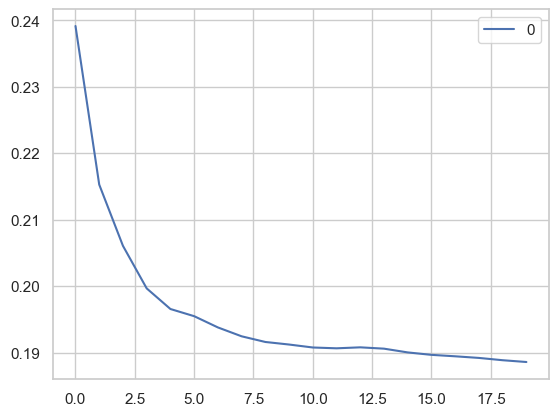

In [98]:
#plotting the rmse values against k values
curve_unique = pd.DataFrame(rmse_val_unique) #elbow curve 
curve_unique.plot()

<AxesSubplot:>

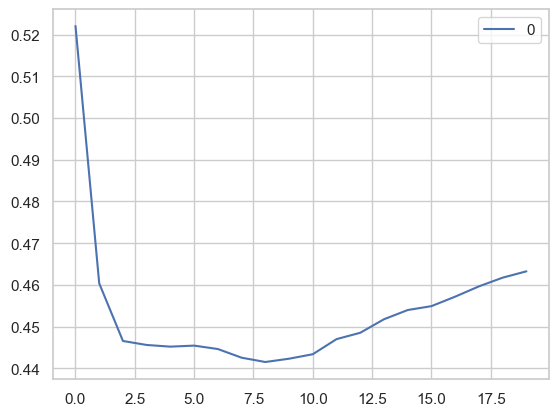

In [99]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [100]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(Xdf_train,ydf_train)
model.best_params_

{'n_neighbors': 20}

In [101]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(Xs2_train,ys2_train)
model.best_params_

{'n_neighbors': 20}

### 12. Grid-Search

In [102]:
from sklearn.model_selection import GridSearchCV

In [103]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }

In [104]:
GBR = GradientBoostingRegressor()
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(Xdf_train, ydf_train)

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [100, 500, 1000, 1500],
                         'subsample': [0.9, 0.5, 0.2, 0.1]})

In [105]:
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)


 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=500,
                          subsample=0.1)

 The best score across ALL searched params:
 0.8715897667148912

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.1}


In [106]:

params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(Xdf_train,ydf_train)
model.best_params_

{'n_neighbors': 20}

### 13. Cross-Validation

In [107]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute

In [108]:
def cross_val(X,y, model):
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  score = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  score = absolute(score)
  print('Mean MAE: %.3f (%.3f)' % (score.mean(), score.std()) )

In [109]:
cross_val(Xdf, ydf, SVR(kernel='linear'))

Mean MAE: 111734.433 (3998.388)


In [110]:
cross_val(Xdf, ydf, GradientBoostingRegressor())

Mean MAE: 100316.826 (3116.980)


In [111]:
cross_val(Xdf, ydf, XGBRegressor())

Mean MAE: 98576.965 (3224.818)
